# DDPG算法

只能用于连续动作，异策略训练

# 导入包

In [1]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import rl_utils
import os

# 策略网络和Q网络

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # 这里直接缩放并输出, 而非像PPO中输出均值方差再采样
        return torch.tanh(self.fc2(x)) * self.action_bound  # 缩放到动作空间


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        # * 拼接状态和动作, 似乎是DDPG首次采用, 之前的Q网络只输入状态, 输出动作状态
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

# DDPG算法

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 sigma, actor_lr, critic_lr, tau, gamma, device, training=True):
        self.training = training
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差, 均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        action = self.actor(state).item()  # * 在这里和网络分离了, 因此后面不需要.item()
        if self.training:
            # 给动作添加噪声，增加探索, 但是验证和测试时不需要
            action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        '''将target_net往net方向软更新, 每次更新幅度都很小

        参数说明
        ----------
        net : torch.nn.module
        target_net : torch.nn.module
        '''
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)

        # 评论员还是时序差分更新, 评论员现在叫Q网络, 但是和之前价值网络一样
        # 不同点是需要输入状态和动作, 动作由演员选择, DQN里面的Q网络不需要输入动作
        # 这也是和DQN的主要区别和改进之处
        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones | truncated)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        # 评论员梯度下降
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # * 注意: 演员是梯度策略, 采用梯度上升, 加负号
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # 一直更新, 但是缓慢更新
        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络


## ✅DDPG注意点

- DDPG引入软更新概念，即对于目标网络的更新，不再是延迟更新，而是每次只更新一点点; 

- 并且把评论员网络变成Q网络，同时输入状态和动作，将它们拼接起来送入网络，之前DQN中没有这样做过，换成Q网络之后，输出一个价值，也就是这个动作状态的价值，但是只有确定性策略，动作是确定的，才能这样设计网络;

- 策略/演员网络直接输出动作，也就是确定性深度策略梯度中`确定性`的来源，之前是输出一个概率，现在是直接确定动作;

# 参数初始化

In [17]:
# DDPG算法相关
PATH = 'checkpoints/DDPG_PDv1.pt'
actor_lr = 3e-4
critic_lr = 3e-3
total_episodes = 200
total_epochs = 10
gamma = 0.98
tau = 0.005  # 软更新参数, tau越小更新幅度越小
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 环境相关
env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 64
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值

agent = DDPG(state_dim, hidden_dim, action_dim, action_bound,
             sigma, actor_lr, critic_lr, tau, gamma, device)

# 其他
policy_name = agent.__class__.__name__  # 算法(类)名称

cuda


In [19]:
env.reset()

(array([0.9715438 , 0.23685996, 0.753903  ], dtype=float32), {})

In [20]:
env.step([1])

(array([0.95732105, 0.28902668, 1.081548  ], dtype=float32),
 -0.1150213541306821,
 False,
 False,
 {})

# 检查点函数

In [21]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic.load_state_dict(checkpoint['critic_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

## 读取检查点

In [22]:
s_epoch, s_episode, return_list = read_ckp(PATH)

# 训练函数

训练速度变慢了, 可能是因为存在四个网络

In [ ]:
return_list = rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, replay_buffer, minimal_size, batch_size, return_list, PATH, 2)

# 作图

效果优于PPO

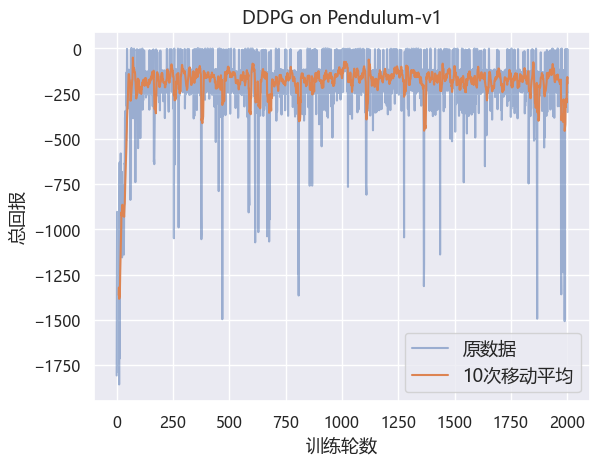

In [7]:
rl_utils.picture_return(return_list, policy_name, env_name, 10)

# 演示策略

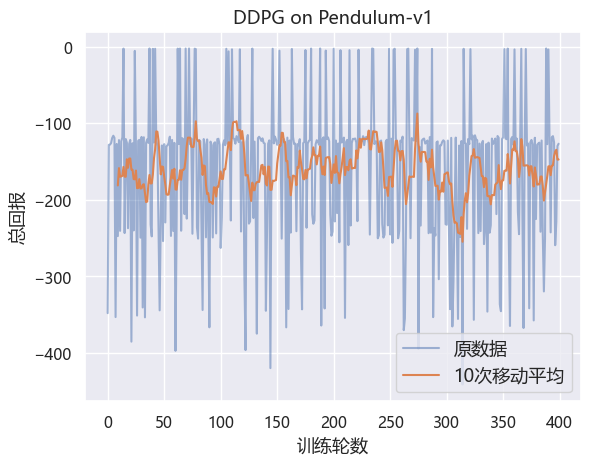

In [8]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'AC', 'rgb_array', epochs=400, if_return=True)

In [9]:
np.mean(test_list)

-160.36631534088386